# Named Entity Recognition (NER) Comparison: spaCy vs Stanza

This notebook demonstrates how to extract named entities from sentences using two different NLP libraries: **spaCy** and **Stanza**. We use a token-level test set and compare the results of both systems.

## 1. Load the NER Test Data

We load the token-level NER test set, which contains columns for sentence ID, token ID, token, and BIO NER tag.

In [2]:
import pandas as pd # Use pandas to read the dataset
ner_test = pd.read_csv(r'NER-test.tsv', sep="\t") # Read the dataset
ner_test.head() # Look at the first 5 rows to ensure the data is read correctly

,sentence_id,token_id,token,BIO_NER_tag
0,0,0,If,O
1,0,1,you're,O
2,0,2,visiting,O
3,0,3,Paris,B-LOCATION
4,0,4,",",O


## 2. Reconstruct Sentences

Since the data is tokenized, we group tokens by `sentence_id` to reconstruct the full sentences for NER processing.

In [3]:
sentences = ner_test.groupby('sentence_id')['token'].apply(lambda tokens: ' '.join(tokens)).reset_index() # Group the data by sentence ID and join the tokens into a single sentence
sentences.columns = ['sentence_id', 'sentence'] # Rename the columns

## 3. Import and Initialize NLP Libraries

We import and initialize the spaCy and Stanza pipelines for English. These will be used to extract named entities from each sentence.

In [4]:
import spacy
import stanza

c:\Users\georg\anaconda3\envs\main\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
nlp_spacy = spacy.load("en_core_web_sm") # Load the English language model

In [6]:
stanza.download("en") # Download the English language model
nlp_stanza = stanza.Pipeline("en") # Load the English language model

2025-05-31 16:53:54 INFO: Downloaded file to C:\Users\georg\stanza_resources\resources.json
2025-05-31 16:53:54 INFO: Downloading default packages for language: en (English) ...
2025-05-31 16:53:54 INFO: File exists: C:\Users\georg\stanza_resources\en\default.zip
2025-05-31 16:53:56 INFO: Finished downloading models and saved to C:\Users\georg\stanza_resources
2025-05-31 16:53:56 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-05-31 16:53:56 INFO: Downloaded file to C:\Users\georg\stanza_resources\resources.json
2025-05-31 16:53:57 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocha

## 4. Define Entity Extraction Functions

We define helper functions to extract entities from a sentence using each library. The functions return a list of (entity text, entity label) pairs.

In [7]:
def extract_entities_spacy(text): # Function to extract entities using spaCy 
    doc = nlp_spacy(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [8]:
def extract_entities_stanza(text): # Function to extract entities using stanza
    doc = nlp_stanza(text)
    return [(ent.text, ent.type) for sent in doc.sentences for ent in sent.ents]

## 5. Apply NER Systems

We apply both spaCy and Stanza NER to each sentence and store the results in new columns.

In [9]:
sentences['spacy_entities'] = sentences['sentence'].apply(extract_entities_spacy) # Apply the spaCy function to each sentence
sentences['stanza_entities'] = sentences['sentence'].apply(extract_entities_stanza) # Apply the stanza function to each sentence

In [10]:
def entities_to_bio_tags(tokens, entities):
    bio_tags = ['O'] * len(tokens)
    for start, end, label, _ in entities:
        bio_tags[start] = 'B-' + label
        for i in range(start + 1, end + 1):
            bio_tags[i] = 'I-' + label
    return bio_tags


In [13]:
def find_entity_span(tokens, entity_text):
    entity_tokens = entity_text.split()
    n = len(entity_tokens)
    for i in range(len(tokens) - n + 1):
        if tokens[i:i+n] == entity_tokens:
            return (i, i+n-1)
    return None


In [14]:
pred_entities_spacy = {}
pred_entities_stanza = {}

for idx, row in sentences.iterrows():
    sent_id = row['sentence_id']
    tokens = ner_test[ner_test['sentence_id'] == sent_id]['token'].tolist()

    spacy_ents = []
    for ent_text, ent_label in row['spacy_entities']:
        span = find_entity_span(tokens, ent_text)
        if span:
            spacy_ents.append((span[0], span[1], ent_label, ent_text))
    pred_entities_spacy[sent_id] = spacy_ents

    stanza_ents = []
    for ent_text, ent_label in row['stanza_entities']:
        span = find_entity_span(tokens, ent_text)
        if span:
            stanza_ents.append((span[0], span[1], ent_label, ent_text))
    pred_entities_stanza[sent_id] = stanza_ents


In [15]:
true_labels = []
pred_labels_spacy = []
pred_labels_stanza = []

for sent_id, group in ner_test.groupby('sentence_id'):
    tokens = group['token'].tolist()
    true_tags = group['BIO_NER_tag'].tolist()

    true_labels.extend(true_tags)

    # Get predicted entities for this sentence
    pred_ents_spacy = pred_entities_spacy.get(sent_id, [])
    pred_ents_stanza = pred_entities_stanza.get(sent_id, [])

    # Convert to BIO tags aligned with tokens
    pred_tags_spacy = entities_to_bio_tags(tokens, pred_ents_spacy)
    pred_tags_stanza = entities_to_bio_tags(tokens, pred_ents_stanza)

    pred_labels_spacy.extend(pred_tags_spacy)
    pred_labels_stanza.extend(pred_tags_stanza)


In [16]:
from sklearn.metrics import classification_report

print("=== spaCy NER Classification Report ===")
print(classification_report(true_labels, pred_labels_spacy, zero_division=0))

print("\n=== Stanza NER Classification Report ===")
print(classification_report(true_labels, pred_labels_stanza, zero_division=0))


=== spaCy NER Classification Report ===
               precision    recall  f1-score   support

   B-CARDINAL       0.00      0.00      0.00         0
       B-DATE       0.00      0.00      0.00         0
      B-EVENT       0.00      0.00      0.00         0
        B-GPE       0.00      0.00      0.00         0
   B-LOCATION       0.00      0.00      0.00         3
        B-ORG       0.50      0.50      0.50         8
     B-PERSON       0.75      0.75      0.75        12
B-WORK_OF_ART       0.33      0.17      0.22         6
       I-DATE       0.00      0.00      0.00         0
      I-EVENT       0.00      0.00      0.00         0
        I-GPE       0.00      0.00      0.00         0
   I-LOCATION       0.00      0.00      0.00         2
        I-ORG       0.57      0.80      0.67         5
     I-PERSON       0.82      0.69      0.75        13
I-WORK_OF_ART       0.33      0.12      0.18         8
            O       0.94      0.93      0.94       159

     accuracy          

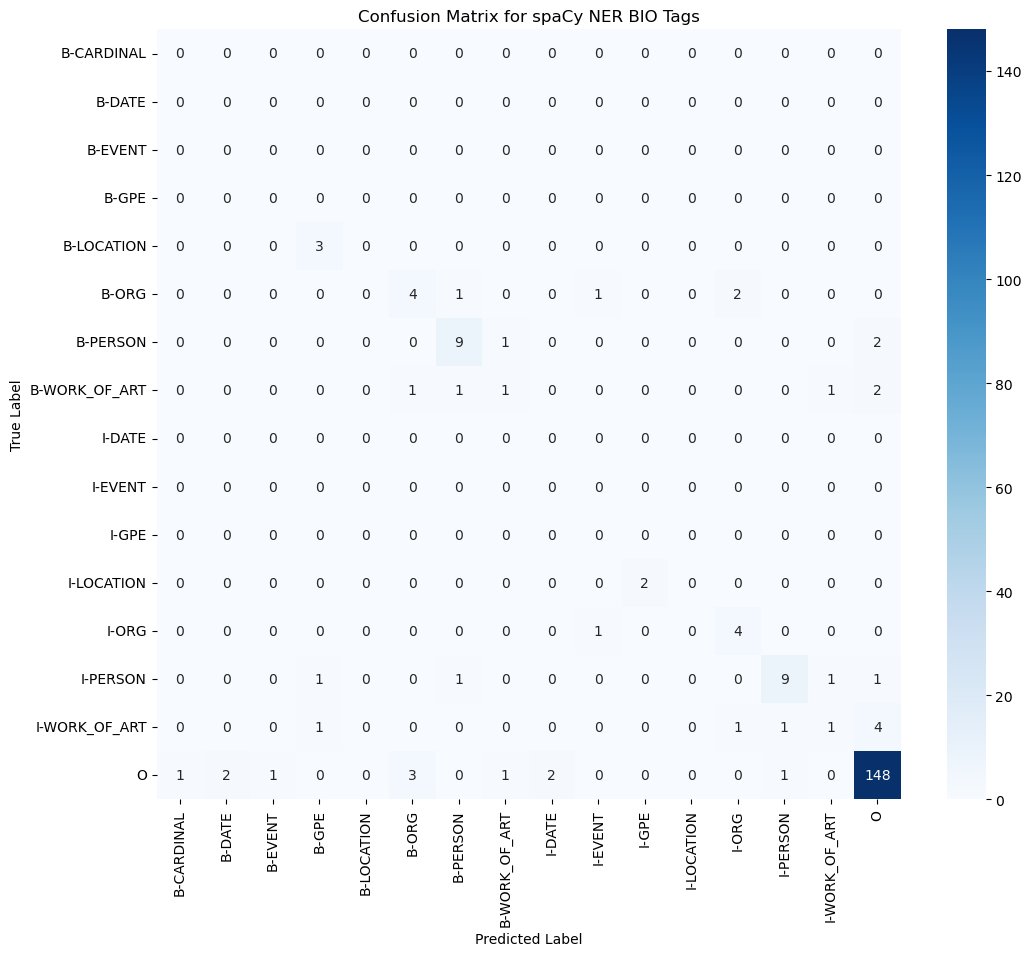

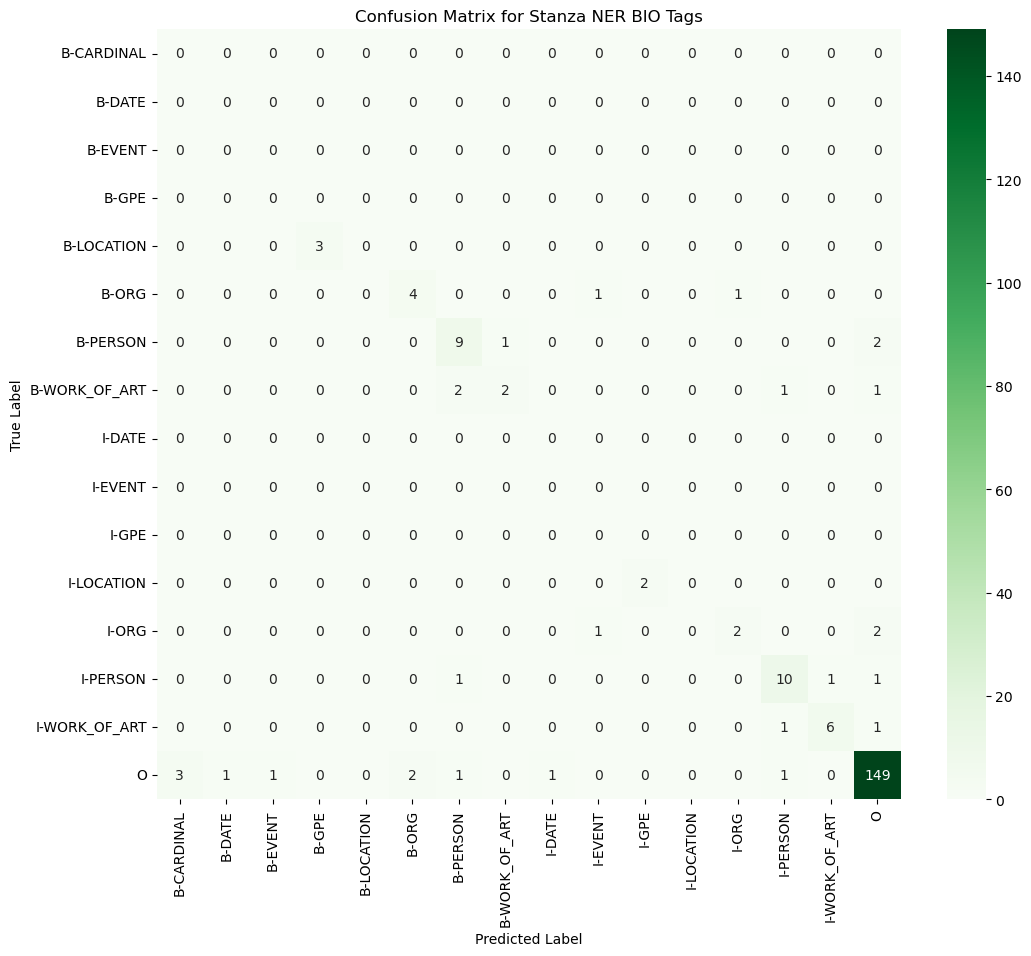

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(list(set(true_labels) | set(pred_labels_spacy)))  # union of true and pred classes

cm_spacy = confusion_matrix(true_labels, pred_labels_spacy, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_spacy, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for spaCy NER BIO Tags')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

cm_stanza = confusion_matrix(true_labels, pred_labels_stanza, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_stanza, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stanza NER BIO Tags')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
